In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [2]:
data = pd.read_csv('./211104/211104 kpeb2.csv', parse_dates = True)

In [3]:
data

,DateTime,Total_Consumption(W),Total_Production(W),Pvt_Supply(W),Pv1_Supply(W),Pv2_Supply(W)
0,2021-08-20 14:33:00,15,0,0,0,0
1,2021-08-20 14:34:00,15,0,0,0,0
2,2021-08-20 14:35:00,15,0,0,0,0
3,2021-08-20 14:36:00,15,0,0,0,0
4,2021-08-20 14:37:00,15,0,0,0,0
...,...,...,...,...,...,...
96669,2021-11-04 16:28:00,130,171,-44,92,79
96670,2021-11-04 16:29:00,131,165,-45,88,76
96671,2021-11-04 16:30:00,130,162,-45,86,76
96672,2021-11-04 16:31:00,130,158,-45,84,75


In [4]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'Total_Consumption(W)', 'Total_Production(W)', 'Pvt_Supply(W)', 'Pv1_Supply(W)', 'Pv2_Supply(W)']


In [5]:
df_kpeb2 = pd.DataFrame()
df_kpeb2['Time'] = data['DateTime']
df_kpeb2['Cons_kpeb2(W)'] = data['Total_Consumption(W)']
df_kpeb2['Prod_kpeb2(W)'] = data['Total_Production(W)']

df_kpeb2.head()


,Time,Cons_kpeb2(W),Prod_kpeb2(W)
0,2021-08-20 14:33:00,15,0
1,2021-08-20 14:34:00,15,0
2,2021-08-20 14:35:00,15,0
3,2021-08-20 14:36:00,15,0
4,2021-08-20 14:37:00,15,0


In [6]:
df_kpeb2['Time'] = pd.to_datetime(df_kpeb2['Time'])

In [7]:
df_kpeb2=df_kpeb2[(df_kpeb2['Time']>='2021-09-13 00:00:00')]
df_kpeb2=df_kpeb2[(df_kpeb2['Time']<'2021-11-04 00:00:00')]

In [9]:
df_kpeb2 = df_kpeb2[df_kpeb2['Cons_kpeb2(W)']< 500]

In [10]:
df_kpeb2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65312 entries, 30336 to 95680
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           65312 non-null  datetime64[ns]
 1   Cons_kpeb2(W)  65312 non-null  int64         
 2   Prod_kpeb2(W)  65312 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.0 MB


In [11]:
df_kpeb2['Cons_kpeb2(W)'] = df_kpeb2['Cons_kpeb2(W)'].astype(float)
df_kpeb2['Prod_kpeb2(W)'] = df_kpeb2['Prod_kpeb2(W)'].astype(float)

In [12]:
df_kpeb2=df_kpeb2.set_index('Time')
df_kpeb2=df_kpeb2.resample('1T').mean()

In [13]:
df_kpeb2['Cons_acc_kpeb2(Wh)'] = df_kpeb2['Cons_kpeb2(W)'].cumsum()*60/3600
df_kpeb2['Prod_acc_kpeb2(Wh)'] = df_kpeb2['Prod_kpeb2(W)'].cumsum()*60/3600

In [14]:
df_kpeb2['denominator'] = df_kpeb2.loc[:,['Cons_kpeb2(W)','Prod_kpeb2(W)']].min(axis=1)
df_kpeb2['denominator_acc'] = df_kpeb2.loc[:,['Cons_acc_kpeb2(Wh)','Prod_acc_kpeb2(Wh)']].min(axis=1)

In [15]:
df_kpeb2['SCF'] = df_kpeb2['denominator']/df_kpeb2['Prod_kpeb2(W)']
df_kpeb2['LCF'] = df_kpeb2['denominator']/df_kpeb2['Cons_kpeb2(W)']

In [16]:
df_kpeb2['SCF_acc'] = df_kpeb2['denominator_acc']/df_kpeb2['Prod_acc_kpeb2(Wh)']
df_kpeb2['LCF_acc'] = df_kpeb2['denominator_acc']/df_kpeb2['Cons_acc_kpeb2(Wh)']
df_kpeb2['self_sustain'] = df_kpeb2['Prod_acc_kpeb2(Wh)']/df_kpeb2['Cons_acc_kpeb2(Wh)']
df_kpeb2['Avg_SCF&LCF'] = (df_kpeb2['SCF_acc']+df_kpeb2['LCF_acc'])/2

In [17]:
df_kpeb2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74879 entries, 2021-09-13 00:01:00 to 2021-11-03 23:59:00
Freq: T
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cons_kpeb2(W)       65312 non-null  float64
 1   Prod_kpeb2(W)       65312 non-null  float64
 2   Cons_acc_kpeb2(Wh)  65312 non-null  float64
 3   Prod_acc_kpeb2(Wh)  65312 non-null  float64
 4   denominator         65312 non-null  float64
 5   denominator_acc     65312 non-null  float64
 6   SCF                 39256 non-null  float64
 7   LCF                 65305 non-null  float64
 8   SCF_acc             65309 non-null  float64
 9   LCF_acc             65312 non-null  float64
 10  self_sustain        65312 non-null  float64
 11  Avg_SCF&LCF         65309 non-null  float64
dtypes: float64(12)
memory usage: 7.4 MB


In [18]:
df_kpeb2

,Cons_kpeb2(W),Prod_kpeb2(W),Cons_acc_kpeb2(Wh),Prod_acc_kpeb2(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,
2021-09-13 00:01:00,25.0,0.0,0.416667,0.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:03:00,25.0,0.0,0.833333,0.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:04:00,25.0,0.0,1.250000,0.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:05:00,24.0,1.0,1.650000,0.016667,1.0,0.016667,1.0,0.041667,1.000000,0.010101,0.010101,0.505051
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,122.0,0.0,107973.416667,647366.166667,0.0,107973.416667,NaN,0.000000,0.166789,1.000000,5.995607,0.583394
2021-11-03 23:56:00,123.0,0.0,107975.466667,647366.166667,0.0,107975.466667,NaN,0.000000,0.166792,1.000000,5.995493,0.583396
2021-11-03 23:57:00,127.0,0.0,107977.583333,647366.166667,0.0,107977.583333,NaN,0.000000,0.166795,1.000000,5.995376,0.583398


In [19]:
df_kpeb2.to_csv('./211109_kpeb2.csv')

# Scatter plotting

KeyError: 'Time'

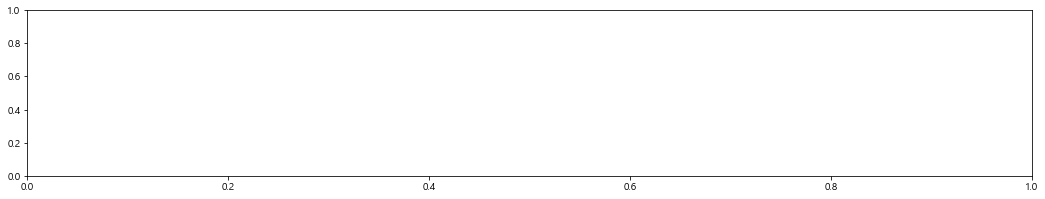

In [20]:
fig, ax = plt.subplots(figsize=(18,50))


for i in range(len(df_kpeb2.columns)):
    plt.subplot(len(df_kpeb2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kpeb2.columns[i]
    plt.scatter(x=df_kpeb2['Time'], y=df_kpeb2[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line plotting

In [21]:
df_kpeb2=df_kpeb2.set_index('Time')

KeyError: "None of ['Time'] are in the columns"

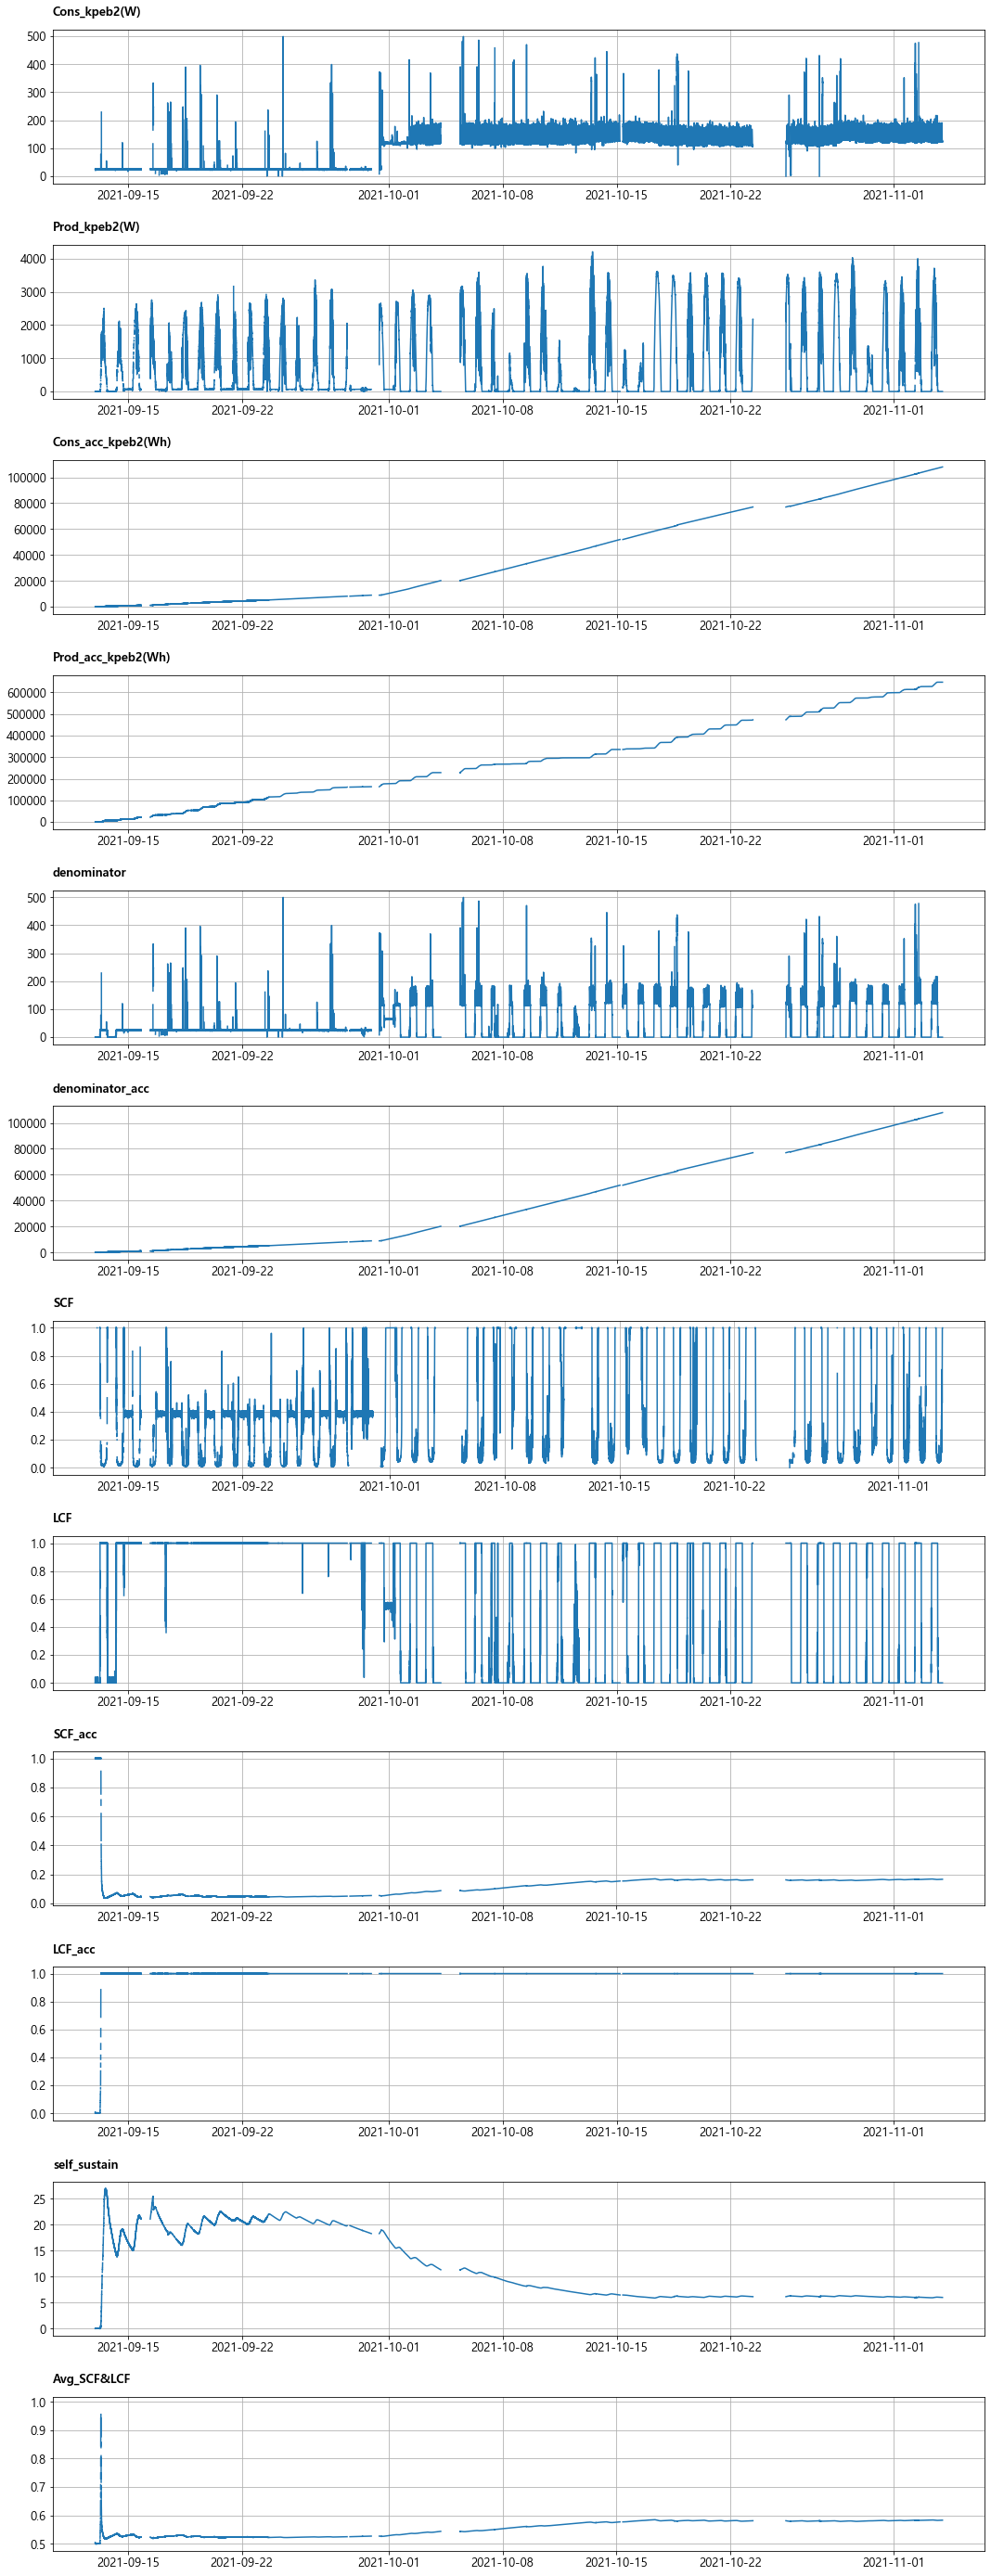

In [22]:
fig, ax = plt.subplots(figsize=(18,50))

for i in range(len(df_kpeb2.columns)):
    plt.subplot(len(df_kpeb2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpeb2.columns[i]
    plt.plot(df_kpeb2[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-08-31'))    
    plt.grid(True)
plt.show()
fig.tight_layout()